Load in data and check class ratio

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize, Imputer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from pandasql import sqldf, PandaSQL
from sklearn.linear_model import LinearRegression
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
salaries = pd.read_csv("C:/Users/Nermin/Downloads/output/Salaries.csv")
salaries.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [30]:
#salaries.Status[salaries.Status == '']
#salaries.ix[:,'Notes']
# all Notes are nans, so we delete the column
print salaries.Notes.unique()
# There are PT,FT, and Nan
salaries.Status.unique()

[ nan]


array([nan, 'PT', 'FT'], dtype=object)

In [31]:
print salaries.shape
salaries.info()
any(salaries.isnull())
# all the columns that have less than 148654 non-null rows, have NaNs

(148654, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 148654 entries, 0 to 148653
Data columns (total 13 columns):
Id                  148654 non-null int64
EmployeeName        148654 non-null object
JobTitle            148654 non-null object
BasePay             148049 non-null object
OvertimePay         148654 non-null object
OtherPay            148654 non-null object
Benefits            112495 non-null object
TotalPay            148654 non-null float64
TotalPayBenefits    148654 non-null float64
Year                148654 non-null int64
Notes               0 non-null float64
Agency              148654 non-null object
Status              38119 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 15.9+ MB


True

In [32]:
# Status and Notes columns have too many NaNs to be useful so we take them out
salaries = salaries.drop(['Status', 'Notes'], axis=1)
salaries.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Agency
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011,San Francisco
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011,San Francisco
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011,San Francisco
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011,San Francisco
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011,San Francisco


In [33]:
# column has all only one value so its useless and we take it out
print salaries.Agency.unique()
salaries = salaries.drop(['Agency'], axis=1)
salaries.head()

['San Francisco']


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011


Obviously the data is not normalized, as there are values that are outside of the 0-1 range. 

In [34]:
# taking out ID column
salaries = salaries.drop(['Id', 'EmployeeName'], axis=1)
salaries.head()

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411,0,400184,NaN,567595.43,567595.43,2011
1,CAPTAIN III (POLICE DEPARTMENT),155966,245132,137811,NaN,538909.28,538909.28,2011
2,CAPTAIN III (POLICE DEPARTMENT),212739,106088,16452.6,NaN,335279.91,335279.91,2011
3,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916,56120.7,198307,NaN,332343.61,332343.61,2011
4,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134402,9737,182235,NaN,326373.19,326373.19,2011


In [35]:
salaries.dtypes

JobTitle             object
BasePay              object
OvertimePay          object
OtherPay             object
Benefits             object
TotalPay            float64
TotalPayBenefits    float64
Year                  int64
dtype: object

In [36]:
print salaries.OvertimePay.unique()
print salaries.Benefits.unique()
print salaries.OtherPay.unique()
print salaries.BasePay.unique()

[0.0 245131.88 106088.18 ..., '102.70' '56.77' 'Not Provided']
[nan 44430.12 69810.19 ..., '0.13' '1.24' 'Not Provided']
[400184.25 137811.38 16452.6 ..., '13.35' 'Not Provided' '-618.13']
[167411.18 155966.02 212739.13 ..., '6.04' '15.50' 'Not Provided']


In [37]:
# converting the Not Provided to NaNs
salaries.ix[salaries.OvertimePay == 'Not Provided', 'OvertimePay'] = np.nan
salaries.ix[salaries.Benefits == 'Not Provided', 'Benefits'] = np.nan
salaries.ix[salaries.OtherPay == 'Not Provided', 'OtherPay'] = np.nan
salaries.ix[salaries.BasePay == 'Not Provided', 'BasePay'] = np.nan

In [38]:
# using only the rows where BasePay is not null
salaries = salaries[salaries.BasePay.isnull() == False]

In [39]:
salaries.BasePay.unique()

array([167411.18, 155966.02, 212739.13, ..., '17.26', '6.04', '15.50'], dtype=object)

In [40]:
# changing all continuous variables to floats
salaries.OvertimePay = salaries.OvertimePay.astype(float)
salaries.Benefits = salaries.Benefits.astype(float)
salaries.OtherPay = salaries.OtherPay.astype(float)
salaries.BasePay = salaries.BasePay.astype(float)

In [41]:
# getting class column into numpy array
y = salaries.BasePay.values
# taking class column out of pandas dataframe
salaries = salaries.drop('BasePay', axis=1)

In [42]:
len(salaries.JobTitle.unique())

2154

In [43]:
pdsql = lambda q: sqldf(q, globals())

In [44]:
q = """select 
JobTitle,
case when JobTitle like '%fire%' then 'Fire'
when JobTitle like '%police%' then 'Police'
when JobTitle like '%sherif%' then 'Police'
when JobTitle like '%probation%' then 'Police'
when JobTitle like '%Sergeant%' then 'Police'
when JobTitle like '%MTA%' then 'Transit'
when JobTitle like '%transit%' then 'Transit'
when JobTitle like '%anesth%' then 'Medical'
when JobTitle like '%medical%' then 'Medical'
when JobTitle like '%nurs%' then 'Medical'
when JobTitle like '%health%' then 'Medical'
when JobTitle like '%physician%' then 'Medical'
when JobTitle like '%Orthopedic%' then 'Medical'
when JobTitle like '%health%' then 'Medical'
when JobTitle like '%pharm%' then 'Medical'
when JobTitle like '%airport%' then 'Airport'
when JobTitle like '%animal%' then 'Animal'
when JobTitle like '%architect%' then 'Architectural'
when JobTitle like '%court%' then 'Court'
when JobTitle like '%legal%' then 'Court'
when JobTitle like '%MAYOR%' then 'Mayor'
when JobTitle like '%librar%' then 'Library'
when JobTitle like '%parking%' then 'Parking'
when JobTitle like '%Public Works%' then 'Public Works'
when JobTitle like '%Attorney%' then 'Attorney'
when JobTitle like '%MECHANIC%' then 'Automotive'
when JobTitle like '%automotive%' then 'Automotive'
when JobTitle like '%custodian%' then 'Custodian'
when JobTitle like '%engineer%' then 'Engineering'
when JobTitle like '%engr%' then 'Engineering'
when JobTitle like '%account%' then 'Accounting'
when JobTitle like '%Gardener%' then 'Gardening'
when JobTitle like '%General Laborer%' then 'General Laborer'
when JobTitle like '%food serv%' then 'Food Service'
when JobTitle like '%clerk%' then 'Clerk'
when JobTitle like '%porter%' then 'Porter'
else 'Other' end as JobType, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, Year from salaries;"""

In [45]:
salaries_orig = salaries

In [46]:
salaries = pdsql(q)
salaries.head()

,JobTitle,JobType,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,Transit,0.00,400184.25,NaN,567595.43,567595.43,2011
1,CAPTAIN III (POLICE DEPARTMENT),Police,245131.88,137811.38,NaN,538909.28,538909.28,2011
2,CAPTAIN III (POLICE DEPARTMENT),Police,106088.18,16452.60,NaN,335279.91,335279.91,2011
3,WIRE ROPE CABLE MAINTENANCE MECHANIC,Automotive,56120.71,198306.90,NaN,332343.61,332343.61,2011
4,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",Fire,9737.00,182234.59,NaN,326373.19,326373.19,2011


In [47]:
salaries = salaries.drop(['JobTitle'], axis=1)

([<matplotlib.axis.XTick at 0x33314048>,
 <a list of 6 Text xticklabel objects>)

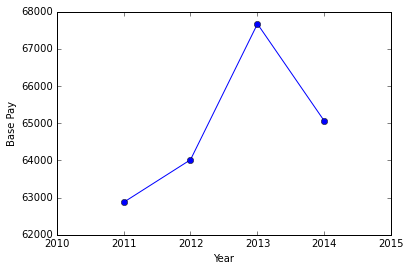

In [59]:
# looking at BasePay by year
year = salaries.Year
base_pay_year = pd.DataFrame(y, columns=['BasePay'])
base_pay_year = pd.concat((base_pay_year, year), axis=1)
byYear = base_pay_year.groupby('Year').aggregate(np.median)
byYear_array = byYear.values
year_array = year.values
plt.plot(np.array([2011, 2012, 2013, 2014]), byYear_array, marker='o')
# add labels
plt.ylabel('Base Pay')
plt.xlabel('Year')
ticks = np.arange(2010, 2016, 1)
labels = np.array(['2010','2011', '2012', '2013', '2014', '2015'])
plt.xticks(ticks, labels)

In [21]:
# Creating Dummy (Indicator) variables for year and job title features
# One-hot-encoding features (making indicator variables)
# getting all categorical feature names
ohe_feats = ['JobType', 'Year']
# for every categorical feature
for f in ohe_feats:
    # create an indicator variable for each unique categorical level
    indicator_vars = pd.get_dummies(salaries[f], prefix=f)
    # drop the categorical feature from the dataset
    salaries = salaries.drop([f], axis=1)
    # concatenate salaries dataframe with the indicator feature dataset for that category
    # excluding the first indicator variable, so that I don't fall into the "dummy variable trap"
    salaries = pd.concat((salaries, indicator_vars.ix[:,1:]), axis=1)

In [22]:
print salaries.shape
salaries.head()

(148045, 30)


,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,JobType_Airport,JobType_Animal,JobType_Architectural,JobType_Attorney,JobType_Automotive,...,JobType_Medical,JobType_Other,JobType_Parking,JobType_Police,JobType_Porter,JobType_Public Works,JobType_Transit,Year_2012,Year_2013,Year_2014
0,0.00,400184.25,NaN,567595.43,567595.43,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,245131.88,137811.38,NaN,538909.28,538909.28,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,106088.18,16452.60,NaN,335279.91,335279.91,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,56120.71,198306.90,NaN,332343.61,332343.61,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,9737.00,182234.59,NaN,326373.19,326373.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
salaries.dtypes

OvertimePay                float64
OtherPay                   float64
Benefits                   float64
TotalPay                   float64
TotalPayBenefits           float64
JobType_Airport            float64
JobType_Animal             float64
JobType_Architectural      float64
JobType_Attorney           float64
JobType_Automotive         float64
JobType_Clerk              float64
JobType_Court              float64
JobType_Custodian          float64
JobType_Engineering        float64
JobType_Fire               float64
JobType_Food Service       float64
JobType_Gardening          float64
JobType_General Laborer    float64
JobType_Library            float64
JobType_Mayor              float64
JobType_Medical            float64
JobType_Other              float64
JobType_Parking            float64
JobType_Police             float64
JobType_Porter             float64
JobType_Public Works       float64
JobType_Transit            float64
Year_2012                  float64
Year_2013           

In [24]:
# converting to Numpy array
X = salaries.values

In [25]:
# performing imputation
# creating imputor object
imp = Imputer()
# imputing the data using mean imputation
X = imp.fit_transform(X)

In [26]:
salaries_2 = pd.DataFrame(X, columns=salaries.columns)
base_pay = pd.Series(y, name='BasePay')
quant_vars = salaries_2.ix[:, :5]
quant_vars.corrwith(base_pay, axis=0)
#plt.matshow(quant_vars.corr())

OvertimePay         0.266740
OtherPay            0.285655
Benefits            0.810267
TotalPay            0.954494
TotalPayBenefits    0.946595
dtype: float64

In [28]:
##### performing normalization on the numeric features
# Getting numeric features
X_num = X[:,0:5]
# Delete those numeric features from the original dataset
X = np.delete(X,[0,1,2,3,4], axis=1)
# Cast dataset from a mix of ints and floats to all floats
#X_num = X_num.astype(float)
# Normalize the numeric features
X_num_norm = normalize(X_num)
# Put the normalized numeric features back into the dataset array
X = np.append(X, X_num_norm, axis=1)
X[:10,:] # look at first ten rows

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.4459982 ,  0.02798949,  0.63257497,  0.63257497],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.30160884,  0.16956232,  0.03090054,  0.66307084,  0.66307084],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0

In [29]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Using Linear Regression algorithm

In [30]:
# getting the Linear Regression algorithm, using add-on to automatically chose features to include in the model
model = LinearRegression(n_jobs=-1) # setting n_jobs = -1, does parallel processing using all of your cores
# performing 10-fold cross-validation (training 10 models) and getting their accuracy (score)
scores = cross_val_score(model, X_train, y_train, cv=10)
# the average accuracy score
scores.mean()

0.41414571919985449

41% accuracy using Linear Regression. This means that there must be nonlinear relationships the algorithm isn't catching

Random Forest Regression using 10 trees

In [32]:
clf = RandomForestRegressor(n_jobs=-1)
scores_2 = cross_val_score(clf, X_train, y_train, cv=10)
scores_2.mean()

0.80915819864212801

81% accuracy so using Random forest regression we are able to take into account nonlinear relationships. 

Tuning the tree parameter, Trying 5 trees and 20 trees

In [42]:
clf_5 = RandomForestRegressor(n_jobs=-1, n_estimators=5)
scores_2_5 = cross_val_score(clf_5, X_train, y_train, cv=10)
scores_2_5.mean()

0.79255700914853233

Accuracy is lower using 5 trees

In [43]:
clf_20 = RandomForestRegressor(n_jobs=-1, n_estimators=20)
scores_2_20 = cross_val_score(clf_20, X_train, y_train, cv=10)
scores_2_20.mean()

0.81634857148199491

Accuracy is lower using 20 trees

Plotting cross-validation accuracy scores against number of trees used

In [48]:
# create numpy array of accuracy scores
acc_scores = np.array([scores_2_5.mean(), scores_2.mean(), scores_2_20.mean()])
# create numpy array of number of trees used
trees_used = np.array([5, 10, 20])

([<matplotlib.axis.XTick at 0x217cc940>,
 <a list of 10 Text xticklabel objects>)

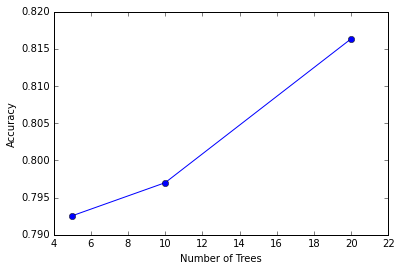

In [54]:
plt.plot(trees_used, acc_scores, marker='o')
# add labels
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
ticks = np.arange(4, 24, 2)
plt.xticks(ticks)

In [55]:
# fitting on the training set
clf_20.fit(X_train,y_train)
# predicting the test set
predicted = clf_20.predict(X_test)

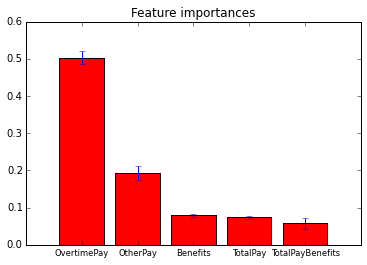

In [75]:
# Looking at the feature importance
importances = clf_20.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_20.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1] # ?

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(5), importances[indices[:5]],
       color="r", yerr=std[indices[:5]], align="center")
rc('xtick', labelsize='large')
plt.xticks(range(5), salaries.columns[[0,1,2,3,4]])
plt.xlim([-1, long(5)])
plt.show()

In [62]:
type(X.shape[1])

long

Problem statement and hypothesis: The problem is to predict the salary of employees of the city of San Francisco based on the JobTitle, OvertimePay, OtherPay, Benefits, TotalPay, TotalPayBenefits, and Year. My hypothesis is that each of these features will have significant prediction power for predicting the salary.

Description of your data set and how it was obtained: I obtained this data from the Kaggle website, in its "datasets" section. The data came in CSV format, with the following 13 columns: 
Id -
EmployeeName -
JobTitle -
BasePay -
OvertimePay -
OtherPay -
Benefits -
TotalPay -
TotalPayBenefits -
Year -
Notes -
Agency -
Status -

There were __ rows in the dataset.

Description of any pre-processing steps you took : The Status and Notes columns have too many NaNs to be useful so we deleted them. Agency had only one value so we took that column out. Took out ID and Employee Name columns since they're useless for modeling. Converted the "Not Provided" values in the OvertimePay, Benefits, OtherPay, and BasePay columns to NaNs. Took out all rows that didn't have values for the target feature (BasePay).

What you learned from exploring the data, including visualizations

How you chose which features to use in your analysis

Details of your modeling process, including how you selected your models and validated them

Your challenges and successes

Possible extensions or business applications of your project

Conclusions and key learnings|